<div align="center">
<font size="6"> OSIC Pulmonary Fibrosis Progression </font>  
</div>

<div align="center">
<font size="4"> Predict lung function decline </font>  
</div>

&nbsp;

<!-- <font size="2"> -->

<img align="right" src="https://www.osicild.org/uploads/1/2/2/7/122798879/editor/kaggle-v01-clipped.png" data-canonical-src="https://www.osicild.org/uploads/1/2/2/7/122798879/editor/kaggle-v01-clipped.png" width="450" height="450" />

Imagine one day, your breathing became consistently labored and shallow. Months later you were finally diagnosed with pulmonary fibrosis, a disorder with no known cause and no known cure, created by scarring of the lungs. If that happened to you, you would want to know your prognosis. That’s where a troubling disease becomes frightening for the patient: outcomes can range from long-term stability to rapid deterioration, but doctors aren’t easily able to tell where an individual may fall on that spectrum. Your help, and data science, may be able to aid in this prediction, which would dramatically help both patients and clinicians.

Current methods make fibrotic lung diseases difficult to treat, even with access to a chest CT scan. In addition, the wide range of varied prognoses create issues organizing clinical trials. Finally, patients suffer extreme anxiety—in addition to fibrosis-related symptoms—from the disease’s opaque path of progression.

[Open Source Imaging Consortium (OSIC)](https://www.osicild.org/) is a **not-for-profit, co-operative effort between academia, industry and philanthropy**. The group enables rapid advances in the fight against **Idiopathic Pulmonary Fibrosis (IPF)**, **fibrosing interstitial lung diseases (ILDs)**, and other respiratory diseases, including emphysematous conditions. Its mission is to bring together radiologists, clinicians and computational scientists from around the world to improve imaging-based treatments.

&nbsp;
<!-- <br/><br/> -->

In this competition, you’ll:
* predict a patient’s severity of decline in lung function based on a CT scan of their lungs;
* determine lung function based on output from a spirometer, which measures the volume of air inhaled and exhaled;
* challenge to use machine learning techniques to make a prediction with the image, metadata, and baseline FVC as input.

Goals:
* patients and their families would better understand their prognosis when they are first diagnosed with this incurable lung disease;
* improved severity detection would positively impact treatment trial design and accelerate the clinical development of novel treatments.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        continue

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import json
from pathlib import Path
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [4]:
data_path = Path('/kaggle/input/osic-pulmonary-fibrosis-progression/')
train_path = data_path / 'train'
test_path = data_path / 'test'
print("training_path", train_path)
print("test_path", test_path)

training_path /kaggle/input/osic-pulmonary-fibrosis-progression/train
test_path /kaggle/input/osic-pulmonary-fibrosis-progression/test


In [5]:
!ls /kaggle/input/osic-pulmonary-fibrosis-progression/

sample_submission.csv  test  test.csv  train  train.csv


# Read DICOM

## What is DICOM?

DICOM (Digital Imaging and Communications in Medicine) is a format that has metadata, as well as Pixeldata attached to it. 
Some basic info can be extracted from image metadata: gender and age of the patient, as well as info how the image is sampled and generated. 

## Import pydicom
Pydicom is a Python package specifically for parsing .dcm files. 

In [6]:
import pydicom
from pydicom.data import get_testdata_files

print(__doc__)

PathDicom = '/kaggle/input/osic-pulmonary-fibrosis-progression/'
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

Automatically created module for IPython interactive environment


In [7]:
print(lstFilesDCM[0])

/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00060637202187965290703/107.dcm


## Get metadata

In [8]:
RefDs = pydicom.dcmread(lstFilesDCM[0])
RefDs

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.140068013088898892389445384277442367502
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 2.25.140068013088898892389445384277442367502
(0008, 0060) Modality                            CS: 'CT'
(0010, 0010) Patient's Name                      PN: 'ID00060637202187965290703'
(0010, 0020) Patient ID                          LO: 'ID00060637202187965290703'
(

In [9]:
# Get ref file
RefDs = pydicom.dcmread(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
print(ConstPixelDims)

(512, 512, 34287)


## Look metadata

In [10]:
pat_name = RefDs.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print("Patient's name................:", display_name)
print("Patient id....................:", RefDs.PatientID)
print("Modality......................:", RefDs.Modality)
print("BodyPartExamined..............:", RefDs.BodyPartExamined)  
print("Image Position    (Patient)...:", RefDs.ImagePositionPatient)
print("Image Orientation (Patient)...:", RefDs.ImageOrientationPatient)

Patient's name................: ID00060637202187965290703, 
Patient id....................: ID00060637202187965290703
Modality......................: CT
BodyPartExamined..............: Chest
Image Position    (Patient)...: [-184.642578125, -368.642578125, -770]
Image Orientation (Patient)...: [1, 0, 0, 0, 1, 0]


## Plot an image

Image size.......: 512 x 512, 524288 bytes
Pixel spacing....: [0.71484375, 0.71484375]
Slice location...: (missing)


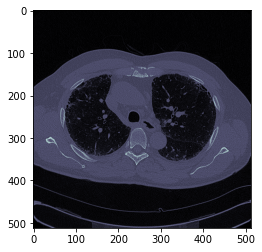

In [11]:
if 'PixelData' in RefDs:
    rows = int(RefDs.Rows)
    cols = int(RefDs.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(rows=rows, cols=cols, size=len(RefDs.PixelData)))
    if 'PixelSpacing' in RefDs:
        print("Pixel spacing....:", RefDs.PixelSpacing) 

        
# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", RefDs.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(RefDs.pixel_array, cmap=plt.cm.bone)
plt.show()

## Plot few images

In [12]:
data = pd.read_csv(data_path / 'test.csv')
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [13]:
data.loc[data['Patient'] == 'ID00422637202311677017371']
#Age is 73, Male

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker


In [14]:
#PATH = '/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00422637202311677017371/'

dim = 25
size = 6
data2Dlist = [[0 for x in range(size)] for y in range(dim)] 

for i in range(0,dim):
    print(i, lstFilesDCM[i])
    data2Dlist[i][0] = pydicom.dcmread(lstFilesDCM[i]).PatientID
    data2Dlist[i][1] = pydicom.dcmread(lstFilesDCM[i]).Modality
    data2Dlist[i][2] = pydicom.dcmread(lstFilesDCM[i]).BodyPartExamined
    data2Dlist[i][3] = pydicom.dcmread(lstFilesDCM[i]).InstanceNumber
    data2Dlist[i][4] = '73'
    data2Dlist[i][5] = 'male'
                      

data2Dlist
df = pd.DataFrame(data2Dlist, columns=['ID', 'Modality', 'BPE', 'Slice', 'Age', 'Sex'])
df
                      
##
#data = pd.DataFrame([{'ID': pydicom.dcmread(lstFilesDCM[i]).PatientID}])
#data['Modality'] = pydicom.dcmread(lstFilesDCM[i]).Modality
#data['BPE'] = pydicom.dcmread(lstFilesDCM[i]).BodyPartExamined
#data['Num'] = pydicom.dcmread(lstFilesDCM[i]).InstanceNumber

0 /kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00060637202187965290703/107.dcm
1 /kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00060637202187965290703/43.dcm
2 /kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00060637202187965290703/194.dcm
3 /kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00060637202187965290703/8.dcm
4 /kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00060637202187965290703/168.dcm
5 /kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00060637202187965290703/81.dcm
6 /kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00060637202187965290703/150.dcm
7 /kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00060637202187965290703/183.dcm
8 /kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00060637202187965290703/89.dcm
9 /kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00060637202187965290703/117.dcm
10 /kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00060637202187965290703/

,ID,Modality,BPE,Slice,Age,Sex
0,ID00060637202187965290703,CT,Chest,107,73,male
1,ID00060637202187965290703,CT,Chest,43,73,male
2,ID00060637202187965290703,CT,Chest,194,73,male
3,ID00060637202187965290703,CT,Chest,8,73,male
4,ID00060637202187965290703,CT,Chest,168,73,male
5,ID00060637202187965290703,CT,Chest,81,73,male
6,ID00060637202187965290703,CT,Chest,150,73,male
7,ID00060637202187965290703,CT,Chest,183,73,male
8,ID00060637202187965290703,CT,Chest,89,73,male
9,ID00060637202187965290703,CT,Chest,117,73,male


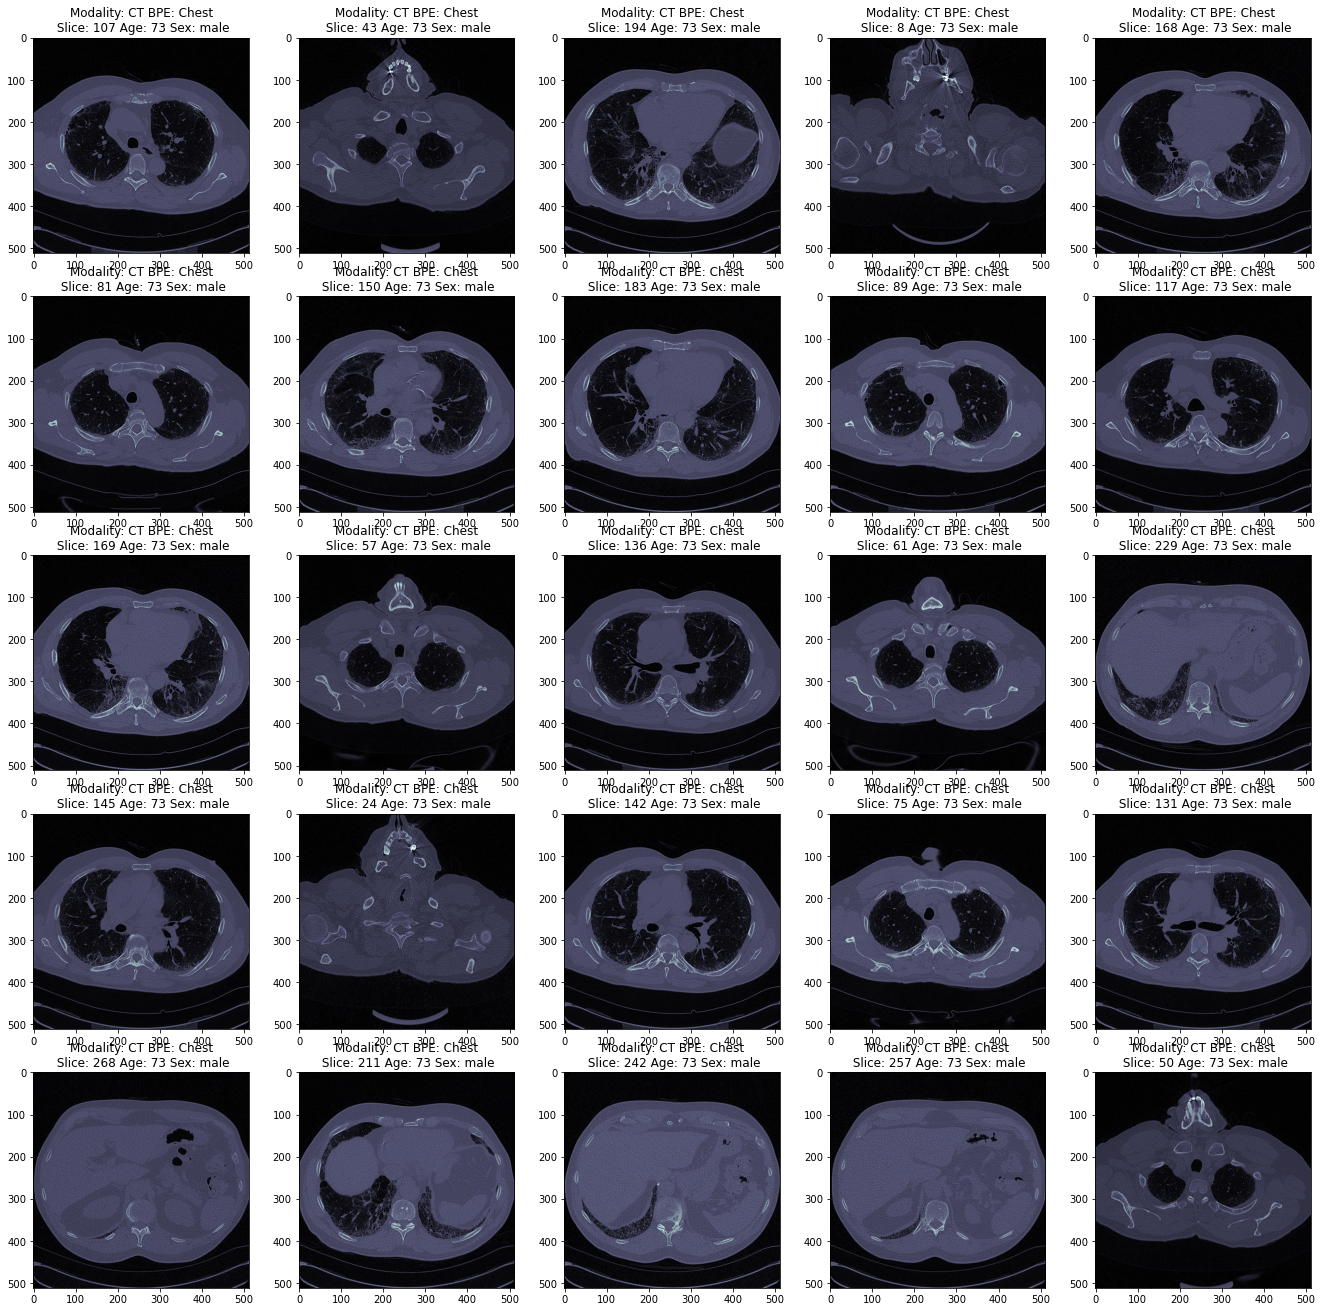

In [15]:
fig, axs = plt.subplots(5,5, figsize=(23,23))

for i in range(0,25):
    RefDs = pydicom.dcmread(lstFilesDCM[i])
    axs[i//5, i%5].imshow(RefDs.pixel_array, cmap=plt.cm.bone) 
    axs[i//5, i%5].set_title('Modality: {} BPE: {}\n Slice: {} Age: {} Sex: {}'.format(df.Modality[i],df.BPE[i],df.Slice[i],df.Age[i],df.Sex[i]))
    
plt.savefig('data_dicom_few_images.png',dpi=300)

plt.show()

# Explore tables

In [16]:
train = pd.read_csv(data_path / 'train.csv')
test  = pd.read_csv(data_path / 'test.csv')
sub   = pd.read_csv(data_path / 'sample_submission.csv')

train.shape, test.shape, sub.shape

((1549, 7), (5, 7), (730, 3))

In [17]:
print('Train:\n',train.head(5),'\n')
print(train.isna().sum())
print('\n---------------------------------------------------------------------------\n')
print('Test:\n',train.head(5),'\n')
print(test.isna().sum())

Train:
                      Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker 

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

---------------------------------------------------------------------------

Test:
                      Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79

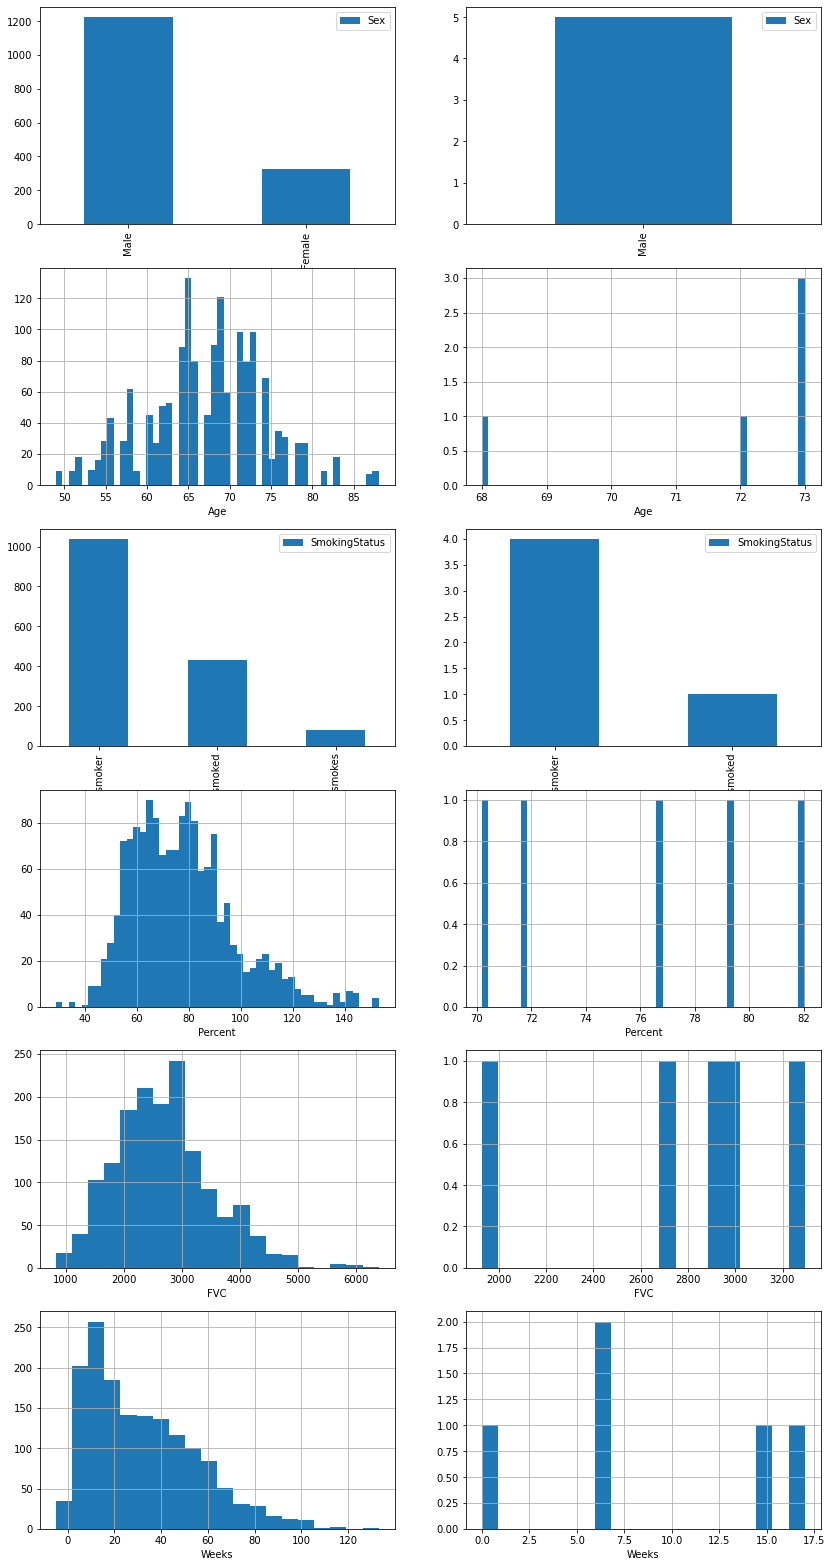

In [18]:
fig, axs = plt.subplots(6,2, figsize=(14,28))

train['Sex'].value_counts().plot(kind='bar', legend=True, ax=axs[0,0])
test['Sex'].value_counts().plot(kind='bar', legend=True, ax=axs[0,1])

train['Age'].hist(bins=50, ax=axs[1,0])
test['Age'].hist(bins=50, ax=axs[1,1])
axs[1,0].set_xlabel('Age')
axs[1,1].set_xlabel('Age')

train['SmokingStatus'].value_counts().plot(kind='bar', legend=True, ax=axs[2,0])
test['SmokingStatus'].value_counts().plot(kind='bar', legend=True, ax=axs[2,1])

train['Percent'].hist(bins=50, ax=axs[3,0])
test['Percent'].hist(bins=50, ax=axs[3,1])
axs[3,0].set_xlabel('Percent')
axs[3,1].set_xlabel('Percent')

train['FVC'].hist(bins=20, ax=axs[4,0])
test['FVC'].hist(bins=20, ax=axs[4,1])
axs[4,0].set_xlabel('FVC')
axs[4,1].set_xlabel('FVC')

train['Weeks'].hist(bins=20, ax=axs[5,0])
test['Weeks'].hist(bins=20, ax=axs[5,1])
axs[5,0].set_xlabel('Weeks')
axs[5,1].set_xlabel('Weeks')

plt.savefig('data_sex_age_smokingstatus_percent_fvc_weeks.png',dpi=300)

plt.show()

## Submission

In [19]:
for i in range(len(test)):
    sub.loc[sub['Patient_Week'].str.contains(test.Patient[i]), 'FVC'] = test.FVC[i]
    
sub.to_csv('submission.csv', index=False)